# EDA for CHGH dataset

In [1]:
!nvidia-smi

Sun Apr  9 08:17:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   32C    P0    47W / 163W |   6896MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup Environment

In [2]:
import matplotlib
%matplotlib inline

# sync python module
%load_ext autoreload
%autoreload 2

## Import Library

In [13]:
import sys
import os
# set package path
sys.path.append("/nfs/Workspace/CardiacSeg")

from monai.data import CacheDataset, DatasetSummary, DataLoader
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    SqueezeDimd
)
from monai.utils import first

import matplotlib.pyplot as plt
import pandas as pd

from data_utils.data_loader_utils import load_data_dict_json, split_data_dicts
from datasets.chgh_dataset import get_data_dicts
from datasets.label_dataset import get_multiple_label_data_dicts, multi_label_to_label_pred_data_dicts
from data_utils.visualization import show_img_lbl
from data_utils.utils import get_data_info, get_pids_by_data_dicts
from data_utils.io import load_json, save_json
from expers.preprocess import get_rel_data_dicts

## Prepare data dicts

In [37]:
# # mmwhs data dict json
# from pprint import pprint
# from datasets.mmwhs_dataset import get_data_dicts

# def get_data_by_idxs(data_dicts, idxs):
#     return get_rel_data_dicts([data_dicts[i] for i in idxs])

# data_dicts_dir = os.path.join('/nfs/Workspace/CardiacSeg', 'exps', 'data_dicts', 'mmwhs')
# data_dicts_json = os.path.join(data_dicts_dir, 'exp_1.json')
# data_dir = '/nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train'

# data_dicts = get_data_dicts(data_dir)
# pids = get_pids_by_data_dicts(data_dicts)
# tr_ds, val_ds, tt_ds = split_data_dicts(data_dicts, fold=4, num_fold=5, split_train_ratio=0.75)

# out_data_dicts = {
#     'train' : get_rel_data_dicts(tr_ds),
#     'val' : get_rel_data_dicts(val_ds),
#     'test' : get_rel_data_dicts(tt_ds)
# }

# pprint(out_data_dicts)
# os.makedirs(data_dicts_dir, exist_ok=True)
# save_json(out_data_dicts, data_dicts_json)

fold: 4
train files (12): ['ct_train_1001_image', 'ct_train_1002_image', 'ct_train_1003_image', 'ct_train_1004_image', 'ct_train_1005_image', 'ct_train_1006_image', 'ct_train_1007_image', 'ct_train_1008_image', 'ct_train_1009_image', 'ct_train_1010_image', 'ct_train_1011_image', 'ct_train_1012_image']
val files (3): ['ct_train_1013_image', 'ct_train_1014_image', 'ct_train_1015_image']
test files (5): ['ct_train_1016_image', 'ct_train_1017_image', 'ct_train_1018_image', 'ct_train_1019_image', 'ct_train_1020_image']
{'test': [{'image': 'ct_train/ct_train_1016_image.nii.gz',
           'label': 'ct_train/ct_train_1016_label.nii.gz'},
          {'image': 'ct_train/ct_train_1017_image.nii.gz',
           'label': 'ct_train/ct_train_1017_label.nii.gz'},
          {'image': 'ct_train/ct_train_1018_image.nii.gz',
           'label': 'ct_train/ct_train_1018_label.nii.gz'},
          {'image': 'ct_train/ct_train_1019_image.nii.gz',
           'label': 'ct_train/ct_train_1019_label.nii.gz'},
    

## Show data info

In [6]:
data_dicts_json =  '/nfs/Workspace/CardiacSeg/exps/data_dicts/mmwhs/exp_1.json'
data_dir = '/nfs/Workspace/CardiacSeg/dataset/mmwhs'
tr_ds, val_ds, tt_ds = load_data_dict_json(data_dir, data_dicts_json)
ds = [*tr_ds, *val_ds]#, *tt_ds]

load json from /nfs/Workspace/CardiacSeg/exps/data_dicts/mmwhs/exp_1.json
train files (12): ['ct_train_1001_image', 'ct_train_1002_image', 'ct_train_1003_image', 'ct_train_1004_image', 'ct_train_1005_image', 'ct_train_1006_image', 'ct_train_1007_image', 'ct_train_1008_image', 'ct_train_1009_image', 'ct_train_1010_image', 'ct_train_1011_image', 'ct_train_1012_image']
val files (3): ['ct_train_1013_image', 'ct_train_1014_image', 'ct_train_1015_image']
test files (5): ['ct_train_1016_image', 'ct_train_1017_image', 'ct_train_1018_image', 'ct_train_1019_image', 'ct_train_1020_image']


pid: ct_train_1001_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1001_image.nii.gz
img shape: [512, 512, 363]
img spacing: [0.35546875, 0.35546875, 0.45]
lbl shape: [512, 512, 363]
lbl spacing: [0.35546875, 0.35546875, 0.45]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


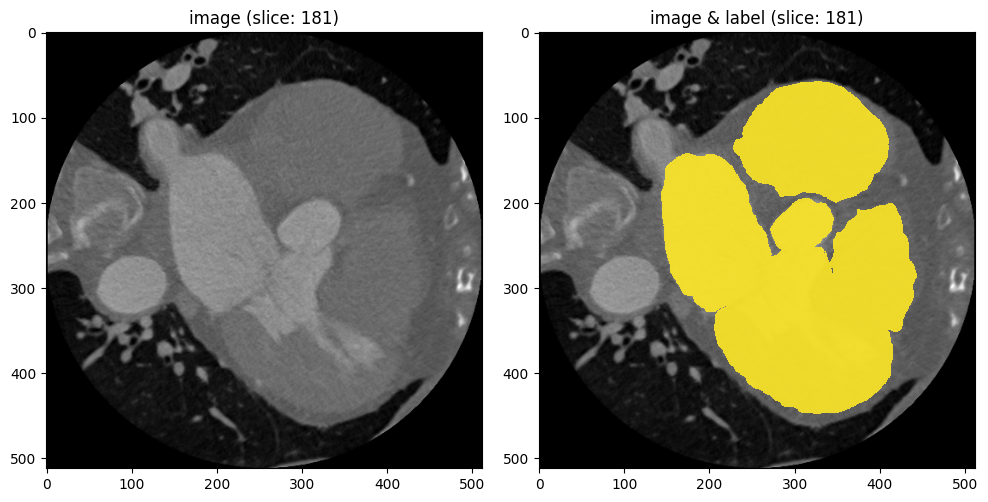

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1002_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1002_image.nii.gz
img shape: [512, 512, 239]
img spacing: [0.488281, 0.488281, 0.625]
lbl shape: [512, 512, 239]
lbl spacing: [0.488281, 0.488281, 0.625]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


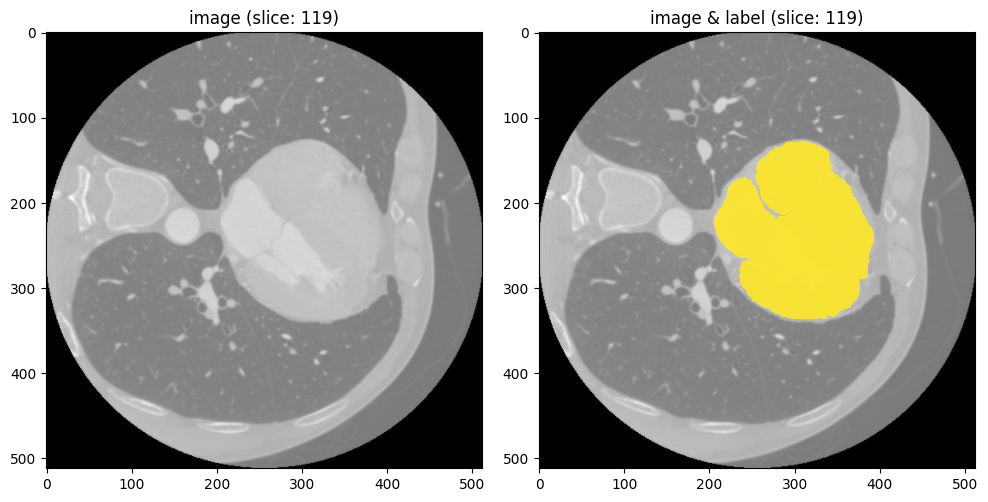

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


KeyboardInterrupt: 

In [8]:
data_info_df = get_data_info(ds)

In [21]:
data_info_df

,pid,img_shape,img_space,lbl_shape,lbl_space,lbl_ids
0,pid_27,"[512, 512, 331]","[0.3828125, 0.3828125, 0.5]","[512, 512, 331]","[0.3828125, 0.3828125, 0.5]","[0.0, 1.0]"
1,pid_30,"[512, 512, 274]","[0.3515625, 0.3515625, 0.5]","[512, 512, 274]","[0.3515625, 0.3515625, 0.5]","[0.0, 1.0]"
2,pid_57,"[512, 512, 411]","[0.47851562, 0.47851562, 0.4]","[512, 512, 411]","[0.47851562, 0.47851562, 0.4]","[0.0, 1.0]"
3,pid_110,"[512, 512, 366]","[0.37890625, 0.37890625, 0.4]","[512, 512, 366]","[0.37890625, 0.37890625, 0.4]","[0.0, 1.0]"
4,pid_1002,"[512, 512, 317]","[0.40625, 0.40625, 0.5]","[512, 512, 317]","[0.40625, 0.40625, 0.5]","[0.0, 1.0]"
5,pid_1003,"[512, 512, 317]","[0.40625, 0.40625, 0.5]","[512, 512, 317]","[0.40625, 0.40625, 0.5]","[0.0, 1.0]"


In [9]:
data_shape_df = pd.DataFrame(data_info_df['img_shape'].to_list(), columns=['w', 'h', 's'])
print('min:', data_shape_df.min().to_list())
print('max:',data_shape_df.max().to_list())
print('mean:',data_shape_df.mean().to_list())

min: [512, 512, 267]
max: [512, 512, 429]
mean: [512.0, 512.0, 340.1333333333333]


In [10]:
data_space_df = pd.DataFrame(data_info_df['img_space'].to_list(), columns=['x', 'y', 'z'])

min_z = data_space_df[['z']].min().values[0]
max_z = data_space_df[['z']].max().values[0]

min_z_df = data_space_df.loc[data_space_df['z'] == min_z]
max_z_df = data_space_df.loc[data_space_df['z'] == max_z]

print('sp xyz mean:',data_space_df.mean().to_list())
print('sp min xy min z:', min_z_df.min().to_list())
print('sp max xy min z:', min_z_df.max().to_list())
print('sp min xy max z:', max_z_df.min().to_list())
print('sp max xy max z:', max_z_df.max().to_list())

sp xyz mean: [0.3834635317325592, 0.3834635317325592, 0.46000003814697266]
sp min xy min z: [0.33203125, 0.33203125, 0.4000000059604645]
sp max xy min z: [0.478515625, 0.478515625, 0.4000000059604645]
sp min xy max z: [0.3359375, 0.3359375, 0.5]
sp max xy max z: [0.416015625, 0.416015625, 0.5]


## Statcics

In [9]:
base_tf = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label'])
])

ds = CacheDataset(
    data=tr_ds,
    transform=base_tf
)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
Loading dataset: 100%|██████████| 12/12 [00:51<00:00,  4.30s/it]


In [10]:
# ref: https://arxiv.org/pdf/1904.08128.pdf
s = DatasetSummary(ds)
s.calculate_percentiles(min_percentile=0.1,max_percentile=99.9)
s.calculate_statistics()
data_target_space = s.get_target_spacing()

In [11]:
print('data target space:')
data_target_space

data target space:


(0.46289050579071045, 0.46289050579071045, 0.625)

In [12]:
print('data intensities statcics:')
data_intensities_statcics = pd.DataFrame(
    [[s.data_min, s.data_median, s.data_max, s.data_mean, s.data_std, s.data_min_percentile, s.data_max_percentile]],
    columns=['min', 'med', 'max', 'mean', 'std', 'min_percentile (0.5%)', 'max_percentile (99.5%)']
)
data_intensities_statcics

data intensities statcics:


,min,med,max,mean,std,min_percentile (0.5%),max_percentile (99.5%)
0,-955.0,227.0,1354.0,268.685394,159.645386,-70.0,677.0


## Transform

In [28]:
space = [1.0,1.0,1.0]
a_min = -42 #s.data_min_percentile
a_max = 423 #s.data_max_percentile
transform = Compose(
      [
          LoadImaged(keys=["image", "label"]),
          AddChanneld(keys=["image", "label"]),
          Orientationd(keys=["image", "label"], axcodes="RAS"),
          Spacingd(
              keys=["image", "label"],
              pixdim=space,
              mode=("bilinear", "nearest"),
          ),
          ScaleIntensityRanged(
              keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True
          ),
          SqueezeDimd(keys=["image", "label"]),
          ToTensord(keys=["image", "label"])
      ]
  )

/opt/conda/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/opt/conda/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


pid: pid_27
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_27/pid_27.nii.gz
img shape: [512, 512, 331]
img spacing: [0.3828125, 0.3828125, 0.5]
lbl shape: [512, 512, 331]
lbl spacing: [0.3828125, 0.3828125, 0.5]
lbl ids: [0. 1.]


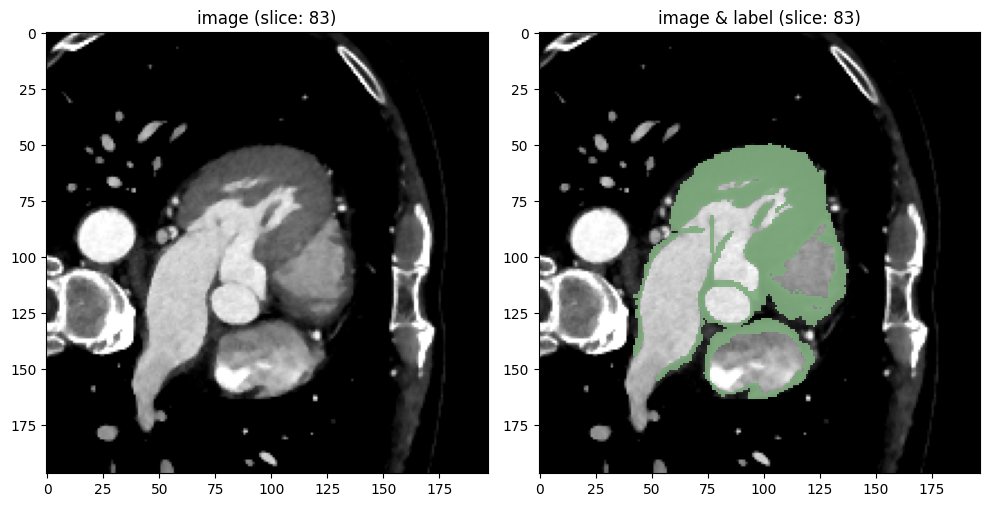

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_30
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_30/pid_30.nii.gz
img shape: [512, 512, 274]
img spacing: [0.3515625, 0.3515625, 0.5]
lbl shape: [512, 512, 274]
lbl spacing: [0.3515625, 0.3515625, 0.5]
lbl ids: [0. 1.]


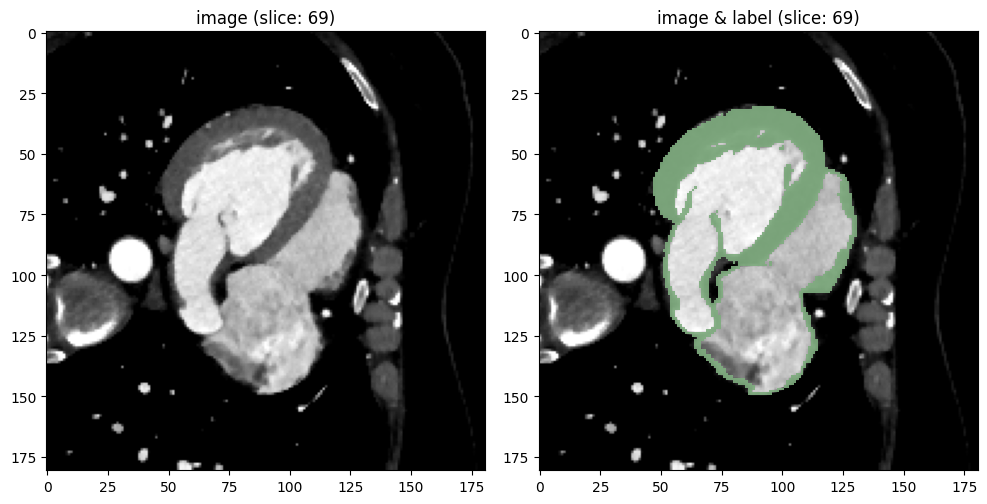

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_57
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_57/pid_57.nii.gz
img shape: [512, 512, 411]
img spacing: [0.47851562, 0.47851562, 0.4]
lbl shape: [512, 512, 411]
lbl spacing: [0.47851562, 0.47851562, 0.4]
lbl ids: [0. 1.]


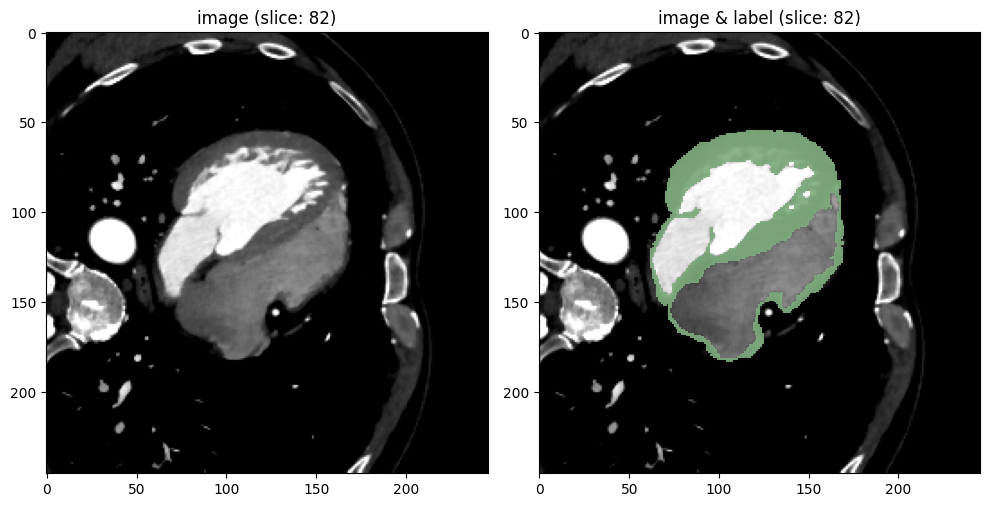

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_110
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_110/pid_110.nii.gz
img shape: [512, 512, 366]
img spacing: [0.37890625, 0.37890625, 0.4]
lbl shape: [512, 512, 366]
lbl spacing: [0.37890625, 0.37890625, 0.4]
lbl ids: [0. 1.]


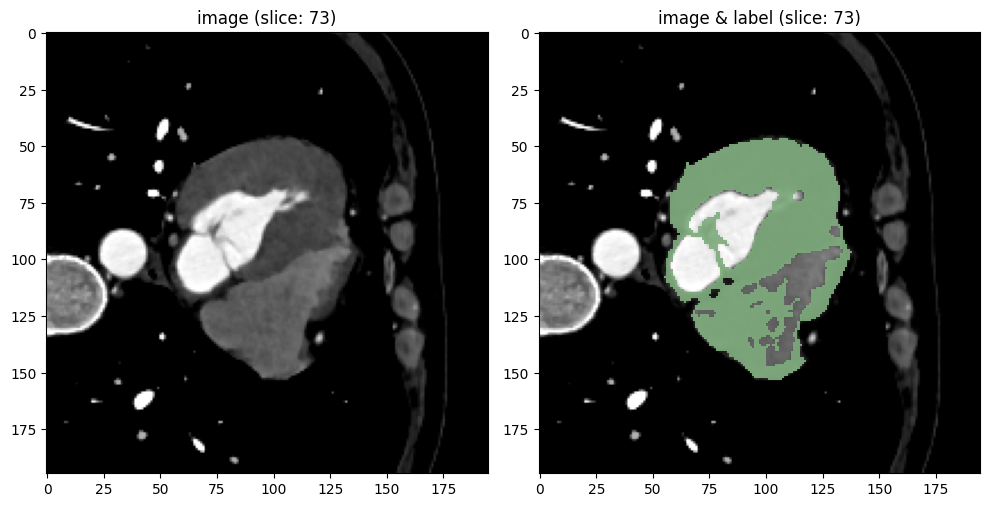

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_1002
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1002/pid_1002.nii.gz
img shape: [512, 512, 317]
img spacing: [0.40625, 0.40625, 0.5]
lbl shape: [512, 512, 317]
lbl spacing: [0.40625, 0.40625, 0.5]
lbl ids: [0. 1.]


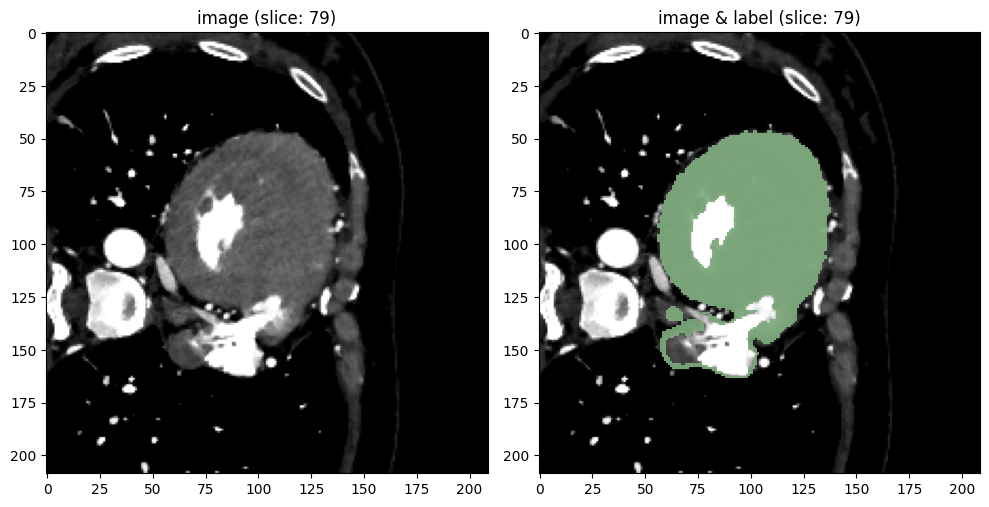

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_1003
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1003/pid_1003.nii.gz
img shape: [512, 512, 317]
img spacing: [0.40625, 0.40625, 0.5]
lbl shape: [512, 512, 317]
lbl spacing: [0.40625, 0.40625, 0.5]
lbl ids: [0. 1.]


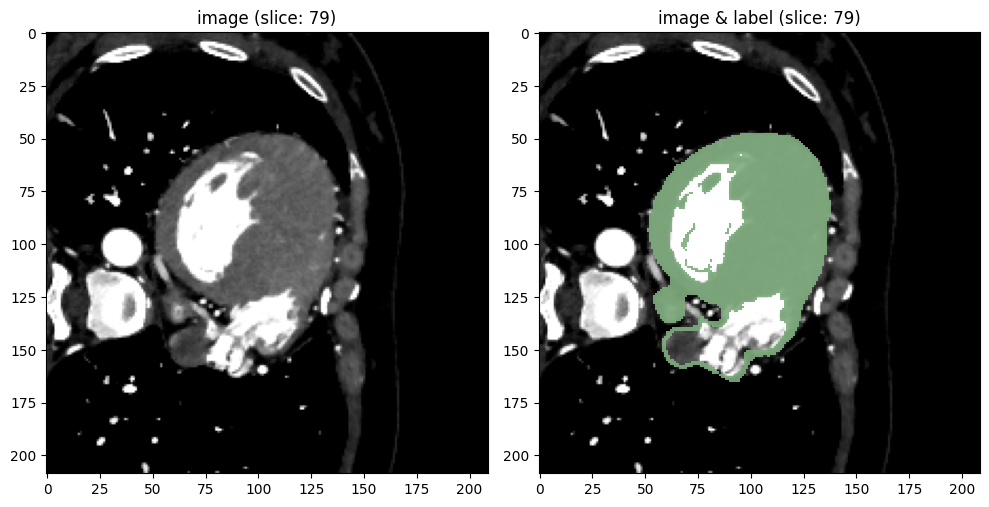

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(


In [29]:
data_info_df = get_data_info(tr_ds, transform)